<a href="https://colab.research.google.com/github/haydendaly/Hand-Drawn-Object-Recognition/blob/master/Model_Project215_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data


**open class names file** and read each line into a list

*we could pick different class names evey time, just by changing items in the list*

In [0]:
classes = ['drums', 'sun', 'laptop', 'book', 'traffic_light', 'wristwatch', 'wheel', 'shovel', 'cake', 'clock', 'broom', 'crown', 'cactus', 'car', 'bicycle', 'donut']

In [0]:
print(classes)

['drums', 'sun', 'laptop', 'book', 'traffic_light', 'wristwatch', 'wheel', 'shovel', 'cake', 'clock', 'broom', 'crown', 'cactus', 'car', 'bicycle', 'donut']


the new list of class names is clean!

## Import the data

1.   Make a new folder called `data` to put images there
2.   Use `urllib.request` to bring the data from the google api
3.   Iterate through items in the `classes` list we created above, and bring in only the data for those things





In [0]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
import urllib.request
def download_image_files():
  location = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20') #replace spaces with %20 because thats how it is with urls
    path = location+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/' + c + '.npy')

In [0]:
download_image_files()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wheel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/shovel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cake.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broom.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/crown.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bit

At this point, all image files (in the form of NumPy objects) have been loaded to the `data` folder.

## Load the .npy files

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class=4000):
  all_files = glob.glob(os.path.join(root, '*.npy'))
  
  #initialize variables
  x = np.empty([0, 784]) #784 is 28x28, the shape of our flattened image. Creates a 0,784 matrix of really small random numbers
  y = np.empty([0])
  class_names = []
  
  #load each data file
  for idx, file in enumerate(all_files):
    data = np.load(file) #place numpy file into data
    data = data[0:max_items_per_class, :] # only use the first X items per class
    labels = np.full(data.shape[0], idx)# ??
    
    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)
    
    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)
  
  data = None
  labels = None

#   #randomize the dataset 
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  #separate into training and testing 
  vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

  x_test = x[0:vfold_size, :]
  y_test = y[0:vfold_size]

  x_train = x[vfold_size:x.shape[0], :]
  y_train = y[vfold_size:y.shape[0]]
  return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
print(x_train.shape)
print(y_train.shape)

(51200, 784)
(51200,)


Set values for the:

*   Number of classes (categories)
*   Image size 




In [0]:
print(class_names)

['cake', 'traffic_light', 'donut', 'book', 'wheel', 'wristwatch', 'laptop', 'sun', 'shovel', 'drums', 'bicycle', 'cactus', 'broom', 'crown', 'car', 'clock']


In [0]:

num_classes = len(class_names)
image_size = 28

**Run the cell below to see a random data point!**



crown


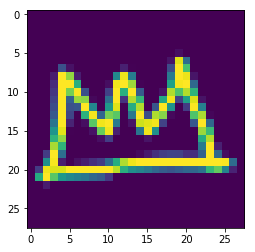

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline


idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) #change this to variables
print(class_names[int(y_train[idx].item())])



# Building a neural network from the labeled data

## Preprocessing the data

### Reshape the data

Currently each image's data is stored flattened as a 784 element array. All 51200 images are in the same x_train matrix:


In [0]:
x_train.shape # as imported

(51200, 784)

### Normalize the data

In machine learning, you don't want to have data of very different dimensions because it slows down learning. Better to divide data by the max to normalize (make every entry a value between 0 and 1)

In [0]:
print(x_train.max()) # before normalization the max value (pure black) is 255

255.0


In [0]:
# Normalize
x_train /= 255.0 # divide each entry of the matrix by 255 so it becomes a float between 0 and 1
x_test /= 255.0

### Reshape the labels

Current labels are placed in an array of size `0, training_examples`.

Convert labels to a matrix of size `(training_examples, num_classes`), with 1 in the position of the correct labels, and 0 elsewhere.

In [0]:
# make the labels ints, they are currently floats
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print("the shape of y_train is: ")
print(y_train.shape)

print("a sample of y_train")
print(y_train)

print("the values in y_train are", set(y_train))

print("the shape of x_train is: ", x_train.shape)

print("a sample of x_train", x_train)

the shape of y_train is: 
(51200,)
a sample of y_train
[ 2  8  7 ...  7  8 12]
the values in y_train are {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
the shape of x_train is:  (51200, 784)
a sample of x_train [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Building the Skeleton of the model

In [0]:
!pip install -q h5py pyyaml 

In [0]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import os

tf.__version__

'1.13.1'

In [0]:
# Define model
def create_model():
  model = tf.keras.models.Sequential([
      keras.layers.Dense(512, activation=tf.keras.activations.relu, input_shape=(784,)),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(16, activation=tf.keras.activations.softmax)
  ])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
  
  return model

mymodel = create_model()
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_28 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 16)                8208      
Total params: 410,128
Trainable params: 410,128
Non-trainable params: 0
_________________________________________________________________


## Train, test and save the NN

model exists but is not trained. To automatically save checkpoints during and at the end of training. This way you can use a trained model without having to retrain it, or pick-up training where you left of—in case the training process was interrupted.

`tf.keras.callbacks.ModelCheckpoint` is a callback that performs this task. The callback takes a couple of arguments to configure checkpointing.

In [0]:
checkpoint_path = "content/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

mymodel = create_model()

mymodel.fit(x_train, y_train,  epochs = 5, 
          validation_data = (x_test,y_test),
          callbacks = [cp_callback] 
          )# pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Train on 51200 samples, validate on 12800 samples
Epoch 1/5
51168/51200 [============================>.] - ETA: 0s - loss: 0.9467 - acc: 0.7257
Epoch 00001: saving model to content/training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
51200/51200 [==============================] - 8s 149us/sample - loss: 0.9464 - acc: 0.7257 - val_loss: 0.6901 - val_acc: 0.8052
Epoch 2/5
51168/51200 [============================>.] - ETA: 0s - loss: 0.6461 - acc: 0.8137
Epoch 00002: saving model to content/training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
51200/51200 [==============================] - 6s 109us/sample - loss: 0.6460 - acc: 0.8137 - val_loss: 0.6296 - val_acc: 0.8192
Epoch 3/5
51168/51200 [============================>.] - ETA: 0s - loss: 0.5408 - acc: 0.8450
Epoch 00003: saving model to content/training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
51200/51200 [==============================] - 6s 109us/sample - loss: 0.5

In [0]:
!ls {str(checkpoint_dir)}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


### Test the accuracy

In [0]:
res_model = create_model()
loss, acc = res_model.evaluate(x_test, y_test)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

12800/12800 [==============================] - 1s 73us/sample - loss: 2.8551 - acc: 0.0509
Untrained model, accuracy:  5.09%


In [0]:
res_model.load_weights(checkpoint_path)
loss,acc = res_model.evaluate(x_test, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

12800/12800 [==============================] - 1s 55us/sample - loss: 0.5809 - acc: 0.8478
Restored model, accuracy: 84.78%
